100%|██████████| 170M/170M [00:04<00:00, 42.6MB/s]


Using device: cpu
Epoch [1/20] Loss: 1.6378  Accuracy: 0.4263
Epoch [2/20] Loss: 1.4314  Accuracy: 0.4983
Epoch [3/20] Loss: 1.3450  Accuracy: 0.5336
Epoch [4/20] Loss: 1.2727  Accuracy: 0.5593
Epoch [5/20] Loss: 1.2109  Accuracy: 0.5826
Epoch [6/20] Loss: 1.1467  Accuracy: 0.6027
Epoch [7/20] Loss: 1.0980  Accuracy: 0.6230
Epoch [8/20] Loss: 1.0373  Accuracy: 0.6458
Epoch [9/20] Loss: 0.9779  Accuracy: 0.6631
Epoch [10/20] Loss: 0.9304  Accuracy: 0.6812
Epoch [11/20] Loss: 0.8809  Accuracy: 0.6996
Epoch [12/20] Loss: 0.8373  Accuracy: 0.7141
Epoch [13/20] Loss: 0.7827  Accuracy: 0.7339
Epoch [14/20] Loss: 0.7437  Accuracy: 0.7479
Epoch [15/20] Loss: 0.7095  Accuracy: 0.7592
Epoch [16/20] Loss: 0.6751  Accuracy: 0.7720
Epoch [17/20] Loss: 0.6377  Accuracy: 0.7873
Epoch [18/20] Loss: 0.6003  Accuracy: 0.8001
Epoch [19/20] Loss: 0.5674  Accuracy: 0.8110
Epoch [20/20] Loss: 0.5243  Accuracy: 0.8256

Total Training Time: 447.87 seconds
Final Test Accuracy: 0.5230


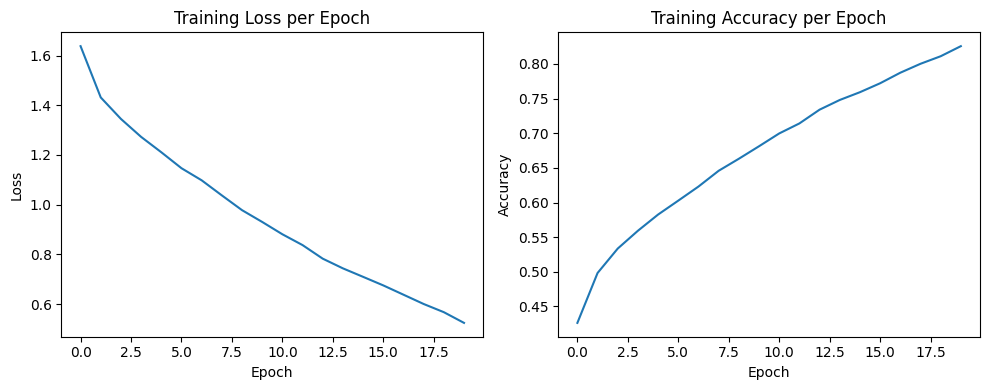

In [1]:
# ============================================
# CIFAR-10 Fully Connected Neural Network (FCNN)
# One Hidden Layer of Size 512
# Reports Training Time, Loss, Accuracy Per Epoch
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

from torch.utils.data import DataLoader

# --------------------------------------------
# 1. Data Loading & Preprocessing
# --------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))  # normalize CIFAR-10 images
])

train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# --------------------------------------------
# 2. Fully Connected NN with One Hidden Layer
# --------------------------------------------
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # flatten 3072 -> 512
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)           # output layer for 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten images
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = FCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# --------------------------------------------
# 3. Training Loop
# --------------------------------------------
num_epochs = 20   # adjust as needed
train_losses = []
train_accuracies = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Loss: {avg_loss:.4f}  Accuracy: {accuracy:.4f}")

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds")


# --------------------------------------------
# 4. Evaluation on Test Set
# --------------------------------------------
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Final Test Accuracy: {test_accuracy:.4f}")


# --------------------------------------------
# 5. OPTIONAL: Plot Loss and Accuracy
# --------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [5]:
# ===============================================================
# CIFAR-10 Deep Fully Connected Neural Network (Google Colab)
# Optimized 300-Epoch Version – NEW AMP API + GPU/CPU Safe
# ===============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0. Device Setup (GPU if available)
# ---------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True   # Speed optimization


# ---------------------------------------------------------
# 1. CIFAR-10 Data Loading
# ---------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=True
)


# ---------------------------------------------------------
# 2. Deep Fully Connected NN (3 Hidden Layers)
# ---------------------------------------------------------
class DeepFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten 32×32×3 → 3072
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = DeepFCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# NEW PYTORCH AMP API (2024+)
if device.type == "cuda":
    scaler = torch.amp.GradScaler(device_type='cuda')
else:
    scaler = None


# ---------------------------------------------------------
# 3. Training Loop (300 Epochs)
# ---------------------------------------------------------
num_epochs = 300
train_losses = []
train_accuracies = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed Precision only on GPU
        if device.type == "cuda":
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")

end_time = time.time()
print(f"\nTotal Training Time: {end_time - start_time:.2f} seconds")


# ---------------------------------------------------------
# 4. Final Test Accuracy
# ---------------------------------------------------------
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = correct / total
print(f"\nFinal Test Accuracy After 300 Epochs: {test_acc:.4f}")


# ---------------------------------------------------------
# 5. Plot Training Loss & Accuracy
# ---------------------------------------------------------
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


Using device: cpu
Epoch 1/300 | Loss: 1.6707 | Train Acc: 0.4038


KeyboardInterrupt: 